In [4]:
import tensorflow as tf
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from albumentations import RandomCrop, HorizontalFlip, VerticalFlip, RandomRotate90

2023-11-09 14:27:22.572727: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 14:27:22.572758: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 14:27:22.572796: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 14:27:22.578327: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [101]:
CONFIGURATION = {
    "N_FILTER":16,
    "IM_SIZE":256,
    "BATCH SIZE":8,
    "N_EPOCH":50,
    "SHUFFLE_SIZE":32
}

# Data import

In [102]:
train_begign_img_path = './dataset/train/img/benign/'
train_malig_img_path = './dataset/train/img/malignant/'
train_normal_img_path = './dataset/train/img/normal/'

train_begign_mask_path = './dataset/train/mask/benign/'
train_malig_mask_path = './dataset/train/mask/malignant/'
train_normal_mask_path = './dataset/train/mask/normal/'

val_begign_img_path = './dataset/val/img/benign/'
val_malig_img_path = './dataset/val/img/malignant/'
val_normal_img_path = './dataset/val/img/normal/'

val_begign_mask_path = './dataset/val/mask/benign/'
val_malig_mask_path = './dataset/val/mask/malignant/'
val_normal_mask_path = './dataset/val/mask/normal/'

test_begign_img_path = './dataset/test/img/benign/'
test_malig_img_path = './dataset/test/img/malignant/'
test_normal_img_path = './dataset/test/img/normal/'

test_begign_mask_path = './dataset/test/mask/benign/'
test_malig_mask_path = './dataset/test/mask/malignant/'
test_normal_mask_path = './dataset/test/mask/normal/'

In [103]:
train_image_paths = []
train_mask_paths = []

val_image_paths = []
val_mask_paths = []

test_image_paths = []
test_mask_paths = []

for i in os.listdir(train_begign_img_path):
    train_image_paths.append(train_begign_img_path+i)
    train_mask_paths.append(train_begign_mask_path+i[:-4] + '_mask.png')

for i in os.listdir(train_malig_img_path):
    train_image_paths.append(train_malig_img_path+i)
    train_mask_paths.append(train_malig_mask_path+i[:-4]+'_mask.png')

for i in os.listdir(train_normal_img_path):
    train_image_paths.append(train_normal_img_path+i)
    train_mask_paths.append(train_normal_mask_path+i[:-4]+'_mask.png')

for i in os.listdir(val_begign_img_path):
    val_image_paths.append(val_begign_img_path+i)
    val_mask_paths.append(val_begign_mask_path+i[:-4] + '_mask.png')

for i in os.listdir(val_malig_img_path):
    val_image_paths.append(val_malig_img_path+i)
    val_mask_paths.append(val_malig_mask_path+i[:-4]+'_mask.png')

for i in os.listdir(val_normal_img_path):
    val_image_paths.append(val_normal_img_path+i)
    val_mask_paths.append(val_normal_mask_path+i[:-4]+'_mask.png')

for i in os.listdir(test_begign_img_path):
    test_image_paths.append(test_begign_img_path+i)
    test_mask_paths.append(test_begign_mask_path+i[:-4] + '_mask.png')

for i in os.listdir(test_malig_img_path):
    test_image_paths.append(test_malig_img_path+i)
    test_mask_paths.append(test_malig_mask_path+i[:-4]+'_mask.png')

for i in os.listdir(test_normal_img_path):
    test_image_paths.append(test_normal_img_path+i)
    test_mask_paths.append(test_normal_mask_path+i[:-4]+'_mask.png')

In [104]:
print(train_image_paths[0])
print(train_mask_paths[0])

print(len(train_image_paths))
print(len(train_mask_paths))

print(val_image_paths[-1])
print(val_mask_paths[-1])

print(len(val_image_paths))
print(len(val_mask_paths))

print(len(test_image_paths))
print(len(test_mask_paths))

./dataset/train/img/benign/benign (136).png
./dataset/train/mask/benign/benign (136)_mask.png
714
714
./dataset/val/img/normal/normal (8).png
./dataset/val/mask/normal/normal (8)_mask.png
45
45
20
20


In [105]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, test_mask_paths))

In [106]:
test_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [107]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [108]:
for i, j in train_dataset.take(1):
    print(i)

tf.Tensor(b'./dataset/train/img/benign/benign (136).png', shape=(), dtype=string)


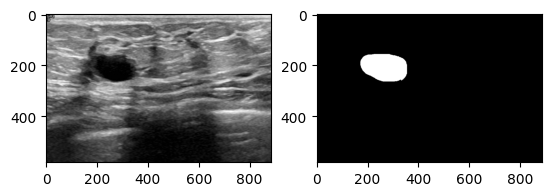

In [109]:
for i, j in train_dataset.take(1):
    # plt.figure(figsize=(12, 12))
    orig = cv2.imread(str(i.numpy())[2:-1])
    # print(orig.shape)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    plt.subplot(1, 2, 1)
    plt.imshow(orig, cmap='gray')
    mask = cv2.imread(str(j.numpy())[2:-1])
    # print(mask.shape)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')

In [110]:
def augmentation(orig, mask, random_crop=0.5, horizontal_flip=0.5, vertical_flip=0.5, random_rotate90=0.5):
    # print('1: ', np.max(orig), np.max(mask))
    aug = RandomCrop(height=192, width=192, p=random_crop)
    augment = aug(image=orig, mask = mask)
    new_orig = augment['image']
    new_mask = augment['mask']

    # print('2: ', np.max(new_orig), np.max(new_mask))
    aug = RandomRotate90(p=random_rotate90)
    augment = aug(image=new_orig, mask=new_mask)
    new_orig = augment['image']
    new_mask = augment['mask']


    # print('3: ', np.max(new_orig), np.max(new_mask))
    aug = HorizontalFlip(p=horizontal_flip)
    augment = aug(image=new_orig, mask=new_mask)
    new_orig = augment['image']
    new_mask = augment['mask']

    # print('4: ', np.max(new_orig), np.max(new_mask))
    aug = VerticalFlip(p=vertical_flip)
    augment = aug(image=new_orig, mask=new_mask)
    new_orig = augment['image']
    new_mask = augment['mask']
    # print('5: ', np.max(new_orig), np.max(new_mask))
    return new_orig, new_mask

In [111]:
def import_image(im_path, mask_path, aug=False):
    image = cv2.imread(str(im_path)[2:-1])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
    image = np.expand_dims(image, -1)
    image = image/255

    mask_image = cv2.imread(str(mask_path)[2:-1])
    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    mask_image = cv2.resize(mask_image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
    mask_image = np.expand_dims(mask_image, -1)
    mask_image = mask_image/255

    if aug==True:
        image, mask_image = augmentation(image, mask_image)

        image = cv2.resize(image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
        mask_image = cv2.resize(mask_image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
        
        # print('im, mask', np.max(image), np.max(mask_image))
    return tf.convert_to_tensor(image, dtype=tf.float32), tf.convert_to_tensor(mask_image, dtype=tf.float32)

In [112]:
def cv_read(im_path, mask_path):
    img, mask = tf.numpy_function(import_image, inp=[im_path, mask_path, False], Tout=[tf.float32, tf.float32])
    img = tf.reshape(img, shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 1))
    mask = tf.reshape(mask, shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 1))
    return img, mask

In [113]:
def cv_read_aug(im_path, mask_path):
    img, mask = tf.numpy_function(import_image, inp=[im_path, mask_path, True], Tout=[tf.float32, tf.float32])
    img = tf.reshape(img, shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 1))
    mask = tf.reshape(mask, shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 1))
    return img, mask

In [114]:
val_dataset = val_dataset.map(cv_read)
train_dataset = train_dataset.map(cv_read_aug)
test_dataset = test_dataset.map(cv_read)

In [115]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None))>

In [116]:
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None))>

In [117]:
for i, j in train_dataset.take(1):
    print(i.shape)

(256, 256, 1)


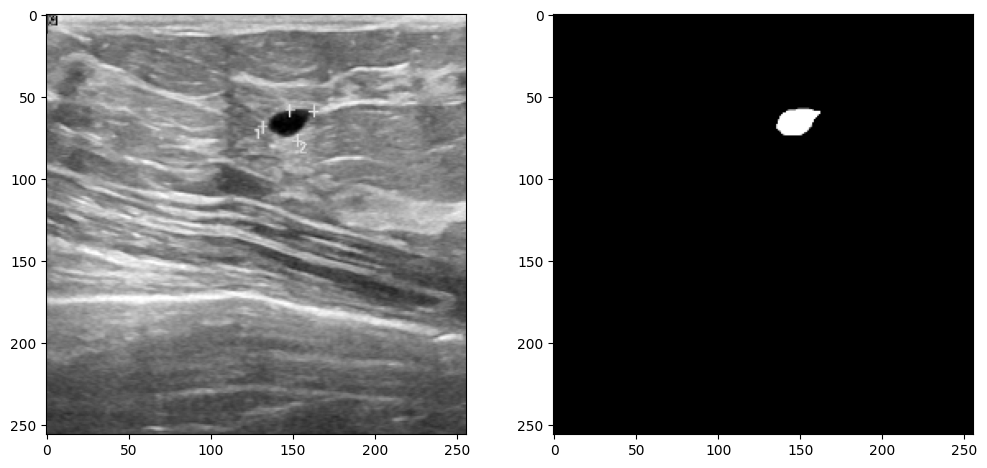

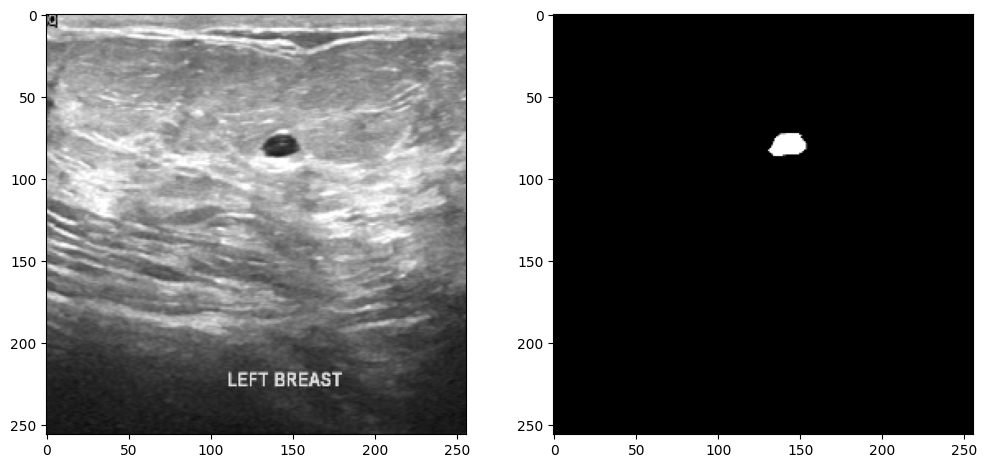

In [118]:
k = 1
for i, j in val_dataset.take(2):
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, k)
    plt.imshow(i, cmap='grey')
    plt.subplot(2, 2, k+1)
    plt.imshow(j, cmap='grey')
    k+=2

In [119]:
train_dataset = (train_dataset
                 .batch(CONFIGURATION['BATCH SIZE'])
                 .shuffle(CONFIGURATION['SHUFFLE_SIZE'], reshuffle_each_iteration=True)
                 .prefetch(tf.data.AUTOTUNE))

In [120]:
val_dataset = (val_dataset
                 .batch(CONFIGURATION['BATCH SIZE'])
                #  .shuffle(128, reshuffle_each_iteration=False)
                 .prefetch(tf.data.AUTOTUNE))

In [121]:
test_dataset = (test_dataset
                 .batch(CONFIGURATION['BATCH SIZE'])
                #  .shuffle(128, reshuffle_each_iteration=False)
                 .prefetch(tf.data.AUTOTUNE))

In [122]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>

In [123]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>

In [124]:
def double_conv_block(x, n_filters):
    x = Conv2D(n_filters, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = Conv2D(n_filters, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(x)

    return x

In [125]:
def downSample_block(x, n_filters):
    conv_out = double_conv_block(x, n_filters)
    pool = MaxPooling2D(pool_size=(2, 2))(conv_out)
    drop = Dropout(0.25)(pool)

    return conv_out, drop

In [126]:
def upsample_block(x, conv_out, n_filters):
    x = Conv2DTranspose(n_filters, (3, 3), (2, 2), padding='same')(x)
    x = concatenate([x, conv_out])
    x = Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [127]:
input = Input(shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 1))

conv1, drop1 = downSample_block(input, CONFIGURATION['N_FILTER']*1)
conv2, drop2 = downSample_block(drop1, CONFIGURATION['N_FILTER']*2)
conv3, drop3 = downSample_block(drop2, CONFIGURATION['N_FILTER']*4)
conv4, drop4 = downSample_block(drop3, CONFIGURATION['N_FILTER']*8)

bottleneck = double_conv_block(drop4, CONFIGURATION['N_FILTER']*16)

uconv4 = upsample_block(bottleneck, conv4, CONFIGURATION['N_FILTER']*8)
uconv3 = upsample_block(uconv4, conv3, CONFIGURATION['N_FILTER']*4)
uconv2 = upsample_block(uconv3, conv2, CONFIGURATION['N_FILTER']*2)
uconv1 = upsample_block(uconv2, conv1, CONFIGURATION['N_FILTER']*1)

output = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(uconv1)

model = Model(input, output)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_57 (Conv2D)          (None, 256, 256, 16)         160       ['input_4[0][0]']             
                                                                                                  
 conv2d_58 (Conv2D)          (None, 256, 256, 16)         2320      ['conv2d_57[0][0]']           
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 128, 128, 16)         0         ['conv2d_58[0][0]']           
 ng2D)                                                                                      

In [128]:
model.compile(
    optimizer='Adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

model_save = ModelCheckpoint('unet_breast.cancer.keras', verbose=1, save_best_only=True, save_weights_only=True)

In [30]:
model.fit(train_dataset, validation_data=val_dataset, epochs=CONFIGURATION['N_EPOCH'], verbose=1,)

Epoch 1/50


2023-11-09 12:52:07.070242: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-09 12:52:09.630657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-09 12:52:10.275089: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-09 12:52:11.387281: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-09 12:5

90/90 [==============================] - ETA: 0s - loss: 8.1277 - accuracy: 0.9122
Epoch 1: val_loss improved from inf to 0.21849, saving model to unet_breast.cancer.keras
90/90 [==============================] - 94s 797ms/step - loss: 8.1277 - accuracy: 0.9122 - val_loss: 0.2185 - val_accuracy: 0.9437
Epoch 2/50
90/90 [==============================] - ETA: 0s - loss: 0.2988 - accuracy: 0.9169
Epoch 2: val_loss improved from 0.21849 to 0.21077, saving model to unet_breast.cancer.keras
90/90 [==============================] - 66s 708ms/step - loss: 0.2988 - accuracy: 0.9169 - val_loss: 0.2108 - val_accuracy: 0.9437
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 0.2780 - accuracy: 0.9187
Epoch 3: val_loss improved from 0.21077 to 0.20573, saving model to unet_breast.cancer.keras
90/90 [==============================] - 68s 723ms/step - loss: 0.2780 - accuracy: 0.9187 - val_loss: 0.2057 - val_accuracy: 0.9437
Epoch 4/50
90/90 [==============================] - ETA: 0

KeyboardInterrupt: 

# evaluate

In [167]:
model.load_weights('./unet_model/unet_breast.cancer.keras')

In [168]:
model.evaluate(test_dataset)

3/3 [==============================] - 0s 85ms/step - loss: 0.1258 - accuracy: 0.9558


[0.12584465742111206, 0.9558318853378296]

In [169]:
predict_benign_path = './dataset/predict/benign/'
predict_malig_path = './dataset/predict/malignant/'
predict_normal_path = './dataset/predict/normal/'

In [170]:
def im_read(im_path):
    image = cv2.imread(im_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
    image = np.expand_dims(image, -1)
    image = np.expand_dims(image, 0)
    image = image/255

    return image

1/1 [==============================] - 0s 22ms/step
0.8033573


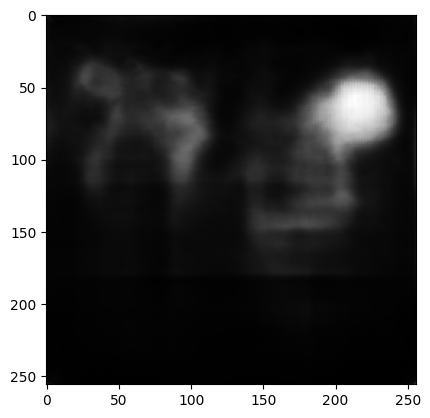

In [171]:
for i in os.listdir(test_malig_img_path):
    image = im_read(test_malig_img_path+i)
    # print(image.shape)
    res = model.predict(image)
    print(np.max(res))
    plt.imshow(res[0], cmap='gray')
    break

In [137]:
for i in os.listdir(test_malig_img_path):
    image = im_read(test_malig_img_path+i)
    # print(image.shape)
    res = model.predict(image)
    cv2.imwrite(predict_malig_path+i, res[0]*255)

1/1 [==============================] - 0s 25ms/step


In [138]:
for i in os.listdir(test_normal_img_path):
    image = im_read(test_normal_img_path+i)
    # print(image.shape)
    res = model.predict(image)
    cv2.imwrite(predict_normal_path+i, res[0]*255)

1/1 [==============================] - 0s 16ms/step


In [139]:
for file in os.listdir(test_begign_img_path):
    image = im_read(test_begign_img_path+file)
    res = model.predict(image)
    
    orig = cv2.imread(test_begign_img_path+file)
    orig = cv2.resize(orig, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
    
    for i in range(res[0].shape[0]):
        for j in range(res[0].shape[1]):
            if(res[0, i, j]>0.3):
                orig[i, j] = [255, 0, 0]

    cv2.imwrite(predict_benign_path+file, orig)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


In [140]:
for file in os.listdir(test_malig_img_path):
    image = im_read(test_malig_img_path+file)
    res = model.predict(image)
    
    orig = cv2.imread(test_malig_img_path+file)
    orig = cv2.resize(orig, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
    
    for i in range(res[0].shape[0]):
        for j in range(res[0].shape[1]):
            if(res[0, i, j]>0.3):
                orig[i, j] = [0, 0, 255]

    cv2.imwrite(predict_malig_path+file, orig)

1/1 [==============================] - 0s 16ms/step


In [141]:
for file in os.listdir(test_normal_img_path):
    image = im_read(test_normal_img_path+file)
    res = model.predict(image)
    
    orig = cv2.imread(test_normal_img_path+file)
    orig = cv2.resize(orig, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
    
    for i in range(res[0].shape[0]):
        for j in range(res[0].shape[1]):
            if(res[0, i, j]>0.3):
                orig[i, j] = [0, 0, 255]

    cv2.imwrite(predict_normal_path+file, orig)

1/1 [==============================] - 0s 17ms/step


# onnx format

#### does not give accurate info in this case

In [143]:
import tf2onnx
import onnxruntime as rt

In [144]:
spec = (tf.TensorSpec(
    (None, 256, 256, 1),dtype=tf.float32, name="input"
),)

output_path = "unet_breast_cancer.onnx"

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13, output_path=output_path)

output_names = [n.name for n in model_proto.graph.output]


Could not search for non-variable resources. Concrete function internal representation may have changed.
2023-11-09 14:38:45.555699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-09 14:38:45.555815: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-11-09 14:38:45.555887: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-11-09 14:38:45.556082: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/A

In [145]:
output_names

['conv2d_75']

In [146]:
import onnxruntime as rt
import cv2
import numpy as np
import os

In [197]:
providers = ['CPUExecutionProvider']

m = rt.InferenceSession('./unet_breast_cancer.onnx', providers=providers)

In [198]:
CONFIGURATION = {
    "IM_SIZE":256
}

In [199]:
test_begign_mask_path = './dataset/test/mask/benign/'
test_malig_mask_path = './dataset/test/mask/malignant/'
test_normal_mask_path = './dataset/test/mask/normal/'

In [200]:
def segment_predict(im_path):
    orig = cv2.imread(im_path)
    image = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
    image = np.array(image, dtype=np.float32)
    image = np.expand_dims(image, -1)
    image = np.expand_dims(image, 0)
    output = m.run(['conv2d_75'], {"input": image})
    output = np.squeeze(output, axis=0)
    return output

In [201]:
for file in os.listdir(test_begign_img_path):
    res = segment_predict(test_begign_img_path+file)
    # print(np.unique(res))
    
    orig = cv2.imread(test_begign_img_path+file)
    orig = cv2.resize(orig, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
    
    for i in range(res[0].shape[0]):
        for j in range(res[0].shape[1]):
            if(res[0, i, j]>0.9):
                orig[i, j] = [255, 0, 0]

    cv2.imwrite(predict_benign_path+file, orig)

# quantization

In [174]:
from onnxruntime.quantization import quantize_dynamic, QuantType

In [175]:
model_fp32 = './unet_breast_cancer.onnx'
model_quant = './unet_breast_cancer_quant.onnx'

quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8)

In [177]:
providers = ['CPUExecutionProvider']

m_q = rt.InferenceSession('./unet_breast_cancer_quant.onnx', providers=providers)

In [179]:
def segment_predict(im_path):
    orig = cv2.imread(im_path)
    image = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
    image = np.array(image, dtype=np.float32)
    image = np.expand_dims(image, -1)
    image = np.expand_dims(image, 0)
    output = m_q.run(['conv2d_75'], {"input": image})
    output = np.squeeze(output, axis=0)
    return output

(1, 256, 256, 1)
1.0


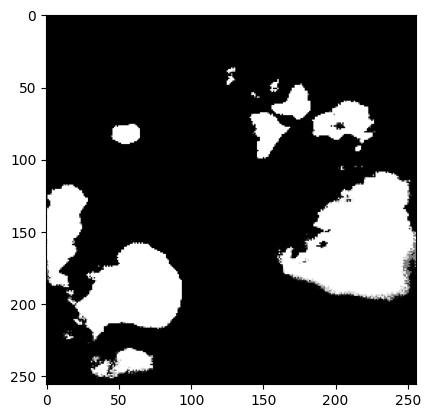

In [188]:
for i in os.listdir(test_begign_img_path):
    res = segment_predict(test_begign_img_path+i)
    print(np.array(res).shape)
    print(np.max(res))
    plt.imshow(res[0], cmap='gray')
    break

In [196]:
for file in os.listdir(test_begign_img_path):
    res = segment_predict(test_begign_img_path+file)
    # print(np.unique(res))
    
    orig = cv2.imread(test_begign_img_path+file)
    orig = cv2.resize(orig, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
    
    for i in range(res[0].shape[0]):
        for j in range(res[0].shape[1]):
            if(res[0, i, j]>0.9):
                orig[i, j] = [255, 0, 0]

    cv2.imwrite(predict_benign_path+file, orig)